## NOTE:
##### 1. RBF-SVM is implemented by using 40k data points.
##### 2. Linear-SVM is implemented by using 2 lakh data points.

## Import necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from scipy.sparse import *
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
import pickle
from tqdm import tqdm
from sklearn.model_selection import  cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
%matplotlib inline

## Load preprocessed data 

In [3]:
#Functions to save objects for later use and retireve it
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".pkl","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".pkl","rb"))
    return temp

#DATA FOR LINEAR SVM
y_train =openfromfile('y_train')
y_test =openfromfile('y_test')

count_vect =openfromfile('count_vect')
X_train_bigram = openfromfile('X_train_bigram')
X_test_bigram = openfromfile('X_test_bigram')

tf_idf_vect =openfromfile('tf_idf_vect')
X_train_tfidf =openfromfile('X_train_tfidf')
X_test_tfidf =openfromfile('X_test_tfidf')

avg_sent_vectors=openfromfile('avg_sent_vectors')
avg_sent_vectors_test=openfromfile('avg_sent_vectors_test')

tfidf_sent_vectors=openfromfile('tfidf_sent_vectors')
tfidf_sent_vectors_test=openfromfile('tfidf_sent_vectors_test')

#DATA FOR RBF SVM
y_train_rbf =openfromfile('y_train_rbf')
y_test_rbf =openfromfile('y_test_rbf')

count_vect_rbf =openfromfile('count_vect_rbf')
X_train_bigram_rbf=openfromfile('X_train_bigram_rbf')
X_test_bigram_rbf=openfromfile('X_test_bigram_rbf')

tf_idf_vect_rbf =openfromfile('tf_idf_vect_rbf')
X_train_tfidf_rbf=openfromfile('X_train_tfidf_rbf')
X_test_tfidf_rbf=openfromfile('X_test_tfidf_rbf')

avg_sent_vectors_rbf=openfromfile('avg_sent_vectors_rbf')
avg_sent_vectors_test_rbf=openfromfile('avg_sent_vectors_test_rbf')

tfidf_sent_vectors_rbf=openfromfile('tfidf_sent_vectors_rbf')
tfidf_sent_vectors_test_rbf=openfromfile('tfidf_sent_vectors_test_rbf')

## Samples Detail: (No. of samples taken)

In [100]:
print('No. of Training Samples (Linear-SVM):',X_train_bigram.shape[0])
print('No. of Training Samples (RBF-SVM):',X_train_bigram_rbf.shape[0])
print('No. of Test Samples (Linear-SVM):',X_test_bigram.shape[0])
print('No. of Test Samples (RBF-SVM):',X_test_bigram_rbf.shape[0])

No. of Training Samples (Linear-SVM): 112123
No. of Training Samples (RBF-SVM): 26190
No. of Test Samples (Linear-SVM): 48053
No. of Test Samples (RBF-SVM): 11225


### Observation:
1. for linear svm all the preprcessing is done on 2 lakh reviews, after preprcessing we left with 1.60 lakh reviews.
2. for rbf svm all the preprcessing is done on 40k reviews, after preprcessing we left with 37.5k lakh reviews.

## Save and Load Model:

In [4]:
def saveModeltofile(obj,filename):
    joblib.dump(obj,open(filename+".pkl","wb"))
def openModelfromfile(filename):
    temp = joblib.load(open(filename+".pkl","rb"))
    return temp

## Standardizing data

In [5]:
def std_data(train,test,mean):
    scaler=StandardScaler(with_mean=mean)
    std_train=scaler.fit_transform(train)
    std_test=scaler.transform(test)
    return std_train, std_test

## Support Vector Machine

### Function for finding optimal value of hyperparameter and plot missclassification error vs hyperparam :

In [8]:
def SVM_Classifier(x_train,y_train,TBS,params,searchMethod,vect,kernel):
    ''' FUNCTION FOR FINDING OPTIMAL VALUE OF HYPERPARAM AND DRAW ERROR PLOT'''
    if kernel=='rbf':
        #INITIALIZE SVC CLASSIFIER WITH RBF-KERNEL
        clf=SVC(class_weight='balanced',kernel=kernel,decision_function_shape='ovr',verbose=3,cache_size=3000)
        hyper_name='C'
    elif kernel=='linear':    
        #INITIALIZE SGDC OBJECT WITH HINGE LOSS 
        clf=SGDClassifier(loss='hinge',penalty='l2',class_weight='balanced',random_state=1)
        hyper_name='alpha'
    # APPLY RANDOM OR GRID SEARCH FOR HYPERPARAMETER TUNNING
    if searchMethod=='grid':
        model=GridSearchCV(clf,\
                           cv=TBS,\
                           n_jobs=-1,\
                           param_grid=params,\
                           return_train_score=True,\
                           scoring=make_scorer(roc_auc_score,average='weighted'))
        model.fit(x_train,y_train)
    elif searchMethod=='random':
        model=RandomizedSearchCV(clf,\
                                 n_jobs=-1,\
                                 cv=TBS,\
                                 param_distributions=params,\
                                 n_iter=len(params[hyper_name]),\
                                 return_train_score=True,\
                                 scoring=make_scorer(roc_auc_score,average='weighted'))
        model.fit(x_train,y_train)
    
    #PLOT HYPERPARAM VS AUC VALUES(FOR BOTH CV AND TRAIN)     
    train_auc= model.cv_results_['mean_train_score']
    train_auc_std= model.cv_results_['std_train_score']
    cv_auc = model.cv_results_['mean_test_score'] 
    cv_auc_std= model.cv_results_['std_test_score']
    plt.figure(1,figsize=(10,6))
    # HERE WE USE LOG FOR CLEAR VISUALIZATION OF ERROR PLOT
    plt.plot(np.log(params[hyper_name]), train_auc, label='Train AUC')
    # REFERENCE LINK: https://stackoverflow.com/a/48803361/4084039
    # gca(): get current axis
    plt.gca().fill_between(np.log(params[hyper_name]),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
    plt.plot(np.log(params[hyper_name]), cv_auc, label='CV AUC')
    # REFERENCE LINK: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(np.log(params[hyper_name]),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
    
    plt.title('ERROR PLOT (%s)' %vect)
    plt.xlabel('log(%s): Hyperparam' %hyper_name)
    plt.ylabel('AUC')
    plt.grid(True)
    plt.legend()
    plt.show()
    return model

### Function for calibration of model and plot calibration curve:

In [9]:
def model_calibration(X_train,X_test,y_train,y_test,best_hyperparam,calibration_method,kernel):
    '''MODEL CALIBRATION AND DRAW CALIBRATION PLOT'''
    i=1;
    calibration_model={}
    #SPLIT DATA INTO TRAIN AND CROSS VALIDATION SET TO MAKE THE DATA DISJOINT
    x_tr,x_cv,y_tr,y_cv=train_test_split(X_train, y_train, test_size=0.3, shuffle=False)
    
    if kernel=='rbf':
        #INITIALIZE SVC WITH RBF KERNEL AND OPTIMAL VALUE OF HYPERPARAM 
        clf=SVC(C=best_hyperparam['C'],\
                kernel=kernel,\
                class_weight='balanced',\
                decision_function_shape='ovr',\
                verbose=3,\
                cache_size=3000)
    elif kernel=='linear':
        #INITIALIZE SGDC WITH HINGE LOSS AND OPTIMAL VALUE OF HYPERPARAM 
        clf=SGDClassifier(alpha=best_hyperparam['alpha'],\
                          class_weight='balanced',\
                          penalty=best_hyperparam['penalty'],\
                          loss='hinge',\
                          n_jobs=-1)
    clf.fit(x_tr,y_tr)
    #PREDICTED PROBABLITY BY A MODEL WITHOUT CALIBRATION
    test_pred_prob_uncalib=clf.decision_function(X_test)
    
    #NORMALIZE DECISION FUNCTION VALUES
    test_pred_prob_uncalib=\
    (test_pred_prob_uncalib-test_pred_prob_uncalib.min())/(test_pred_prob_uncalib.max()-test_pred_prob_uncalib.min())
    
    fop_uc,mop_uc=calibration_curve(y_test,test_pred_prob_uncalib, n_bins=7)
    for cal_method in calibration_method:
        # INITIALIZE CALIBRATION CLASSIFIER FOR BOTH SIGMOID AND ISOTONIC CALIBRATION
        calib_model=CalibratedClassifierCV(clf,cv='prefit',method=cal_method)
        calib_model.fit(x_cv,y_cv)
        calibration_model[cal_method]=calib_model
        test_pred_prob_calib = calib_model.predict_proba(X_test)[:,1]#y_calib
        fop_c,mop_c=calibration_curve(y_test,test_pred_prob_calib, n_bins=7)

        # IDEAL CALIBRATED PLOT
        plt.figure(1,figsize=(15,5))
        plt.subplot(int('12'+str(i)))
        plt.plot([0, 1], [0, 1], linestyle='--', color='black')
        # PLOT MODEL RELIABILITY PLOT
        plt.plot(mop_uc, fop_uc, marker='.',color='red',label='uncalibrated')
        plt.plot(mop_c, fop_c, marker='.',color='green',label='calibrated')
        plt.legend(loc='best')
        plt.title('Calibration Plots ({0})'.format(calibration_method[i-1]))
        i+=1
    plt.show()
    return calibration_model,clf

### Function which calculate performance on test data with optimal hyperparam : 

In [38]:
def test_performance(calib_model,clf,x_train,y_train,x_test,y_test,optimal_hyper,vect,summarize,kernel):
    '''PERFORMANCE ON TEST DATA AND PLOT ROC AND CONFUSION MATRIX WITH OPTIMAL HYPERPARAM'''
    
    data_used=['Test-Data','Train-Data']
    #PROBABILITY SCORE FOR TRAIN DATA 
    calib_train_prob=calib_model.predict_proba(x_train)[:,1]
    #PROBABILITY SCORE FOR TEST DATA
    calib_test_prob=calib_model.predict_proba(x_test)[:,1]

    fpr_test, tpr_test, threshold_test = roc_curve(y_test, calib_test_prob,pos_label=1)
    fpr_train, tpr_train, threshold_train = roc_curve(y_train, calib_train_prob,pos_label=1)
    auc_score_test=auc(fpr_test, tpr_test)
    auc_score_train=auc(fpr_train, tpr_train)
    y_pred={} ; y_act={};
    y_pred[data_used[0]]=clf.predict(x_test)
    y_pred[data_used[1]]=clf.predict(x_train)
    y_act[data_used[0]]=y_test
    y_act[data_used[1]]=y_train
    f1=f1_score(y_test,y_pred[data_used[0]],average='weighted')
    if kernel=='linear':
        #ADD RESULTS TO PRETTY TABLE
        summarize.add_row([vect,kernel, optimal_hyper['penalty'],optimal_hyper['alpha'], '%.4f' %auc_score_test,'%.4f' %f1])
    elif kernel=='rbf':
        summarize.add_row([vect,kernel, optimal_hyper['C'], '%.4f' %auc_score_test,'%.4f' %f1])
    plt.figure(1,figsize=(14,7))
    plt.title('ROC Curve (%s)' %vect)
    #IDEAL ROC CURVE
    plt.plot([0,1],[0,1],'k--')
    #ROC CURVE OF TEST DATA
    plt.plot(fpr_test, tpr_test , 'b', label='Test_AUC= %.2f' %auc_score_test)
    #ROC CURVE OF TRAIN DATA
    plt.plot(fpr_train, tpr_train , 'g', label='Train_AUC= %.2f' %auc_score_train)
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.legend(loc='lower right')
    
    plt.figure(2,figsize=(16,6))
    for k in range(2):
        #PLOT CONFUSION MATRIX USING HEATMAP
        plt.subplot(int('12'+str(k+1)))
        plt.title('Confusion-Matrix (%s)' %data_used[k])
        df_cm = pd.DataFrame(confusion_matrix(y_act[data_used[k]],y_pred[data_used[k]]), ['Negative','Positive'],['Negative','Positive'])
        sns.set(font_scale=1.4)#for label size
        sns.heatmap(df_cm,cmap='gist_earth', annot=True,annot_kws={"size": 16}, fmt='g')
    plt.show()

### Function which print top important fetures and plot them using Bar plot :

In [17]:
#REFERENCE STACKOVERFLOW
def feature_importance(vectorizer,clf,n):
    '''TOP IMPORTANT FEATURE FOR BOTH POSITIVE AND NEGAVTIVE CLASS'''
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\tNegative\t\t\t\t\tPositive\t\t")
    print("_"*75)
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
    
    coef=sorted(clf.coef_[0],reverse=True)
    #STORE WEIGHT CORRESPONDING TO TOP POSITIVE AND NEGATIVE IMPORTANT FEATURES
    coef_p=coef[:n]
    coef_n=coef[:-(n + 1):-1]
    coef_np=coef_n+coef_p
    indices_n=np.argsort(clf.coef_[0])[:n]
    indices_p=np.argsort(clf.coef_[0])[::-1][:n]
    indices=list(indices_n)+list(indices_p)
    names = np.array(vectorizer.get_feature_names())
    #BAR CHART 
    plt.figure(2,figsize=(13,6))
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    plt.title("Feature Importance(top %d positive and negative class features)" % n)
    # ADD BARS
    plt.bar(range(2*n), coef_np)
    # ADD FEATURES NAME
    plt.xticks(range(2*n), names[indices], rotation=80)
    plt.show()

### Initialization of common objects required for all vectorization:

In [18]:
#VECTORIZER
vect=['BoW','TF-IDF','AVG-W2V','TFIDF-W2V']
#OBJECT FOR TIMESERIES CROSS VALIDATION
TBS=TimeSeriesSplit(n_splits=10)
#METHOD USE FOR HYPER PARAMETER TUNNING(FOR FAST PERFORMANCE WE USE randomized)
searchMethod='random'
#RANGE OF VALUES(HYPERPARAM RBF)
c_ranges=[10**x for x in range(-4,5)] #np.logspace(-2,2,5)
params_rbf={'C':c_ranges}
#RANGE OF VALUES(HYPERPARAM LINEAR)
alpha_ranges=np.logspace(-5,5,11)
#REGULARIZER USED
penalty=['l1','l2']
params={'alpha':alpha_ranges,'penalty':penalty}
#KERNEL USED
kernel=['linear','rbf']

## [1] Linear SVM

In [40]:
#INITIALIZE PRETTY TABLE OBJECT
summarize = PrettyTable()
summarize.field_names = ['Vectorizer', 'Kernel','Optimal-Penalty', 'Optimal-Alpha', 'Test(AUC)','Test(f1-score)']

### [1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

#### [1.1.1] Hyperparam tunning and plot Hyperparam v/s Missclassification error:

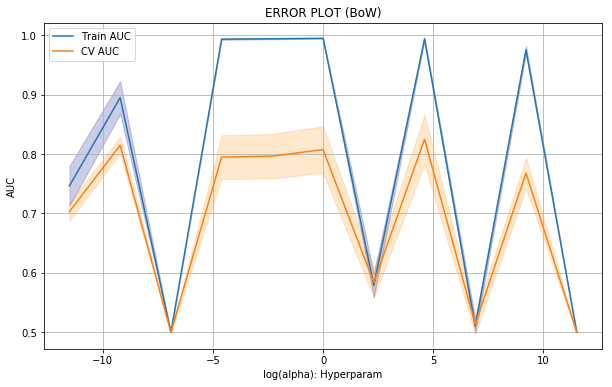

CPU times: user 21.1 s, sys: 608 ms, total: 21.7 s
Wall time: 22.9 s
Optimal value of hyperparam:  {'alpha': 1.0, 'penalty': 'l2'}


In [22]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=X_train_bigram,test=X_test_bigram,mean=False)
#HYPERPARAM TUNNING
%time model=SVM_Classifier(train,y_train,TBS,params,searchMethod,vect[0],kernel[0])
#PRINT OPTIMAL VALUE OF HYPERPARAM
print('Optimal value of hyperparam: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_bow_lsvm')

#### [1.1.2] Calibration of a model and plot calibration curve :
                a. sigmoid
                b. isotonic

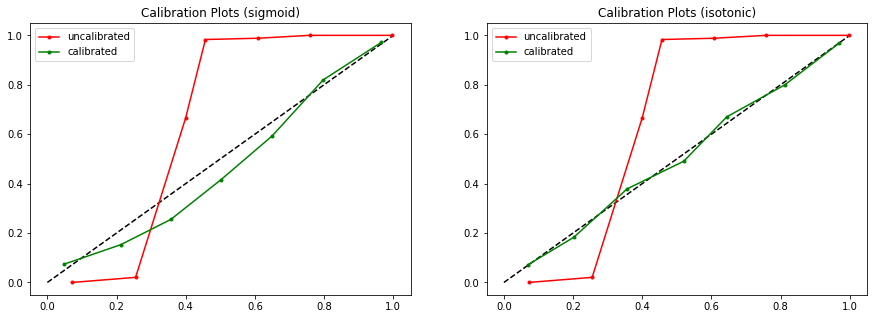

In [23]:
calibration_method=['sigmoid','isotonic']
calib_model,clf=model_calibration(train,test,y_train,y_test,model.best_params_,calibration_method,kernel[0])

## Observation:
1. From the above plot we observe that the uncalibrated curve is looks like a sigmoidal curve so we choose sigmoidal calibration.

In [24]:
calib_mod=calib_model['sigmoid']

#### [1.1.3] Performance on test data with optimal value of hyperparam:

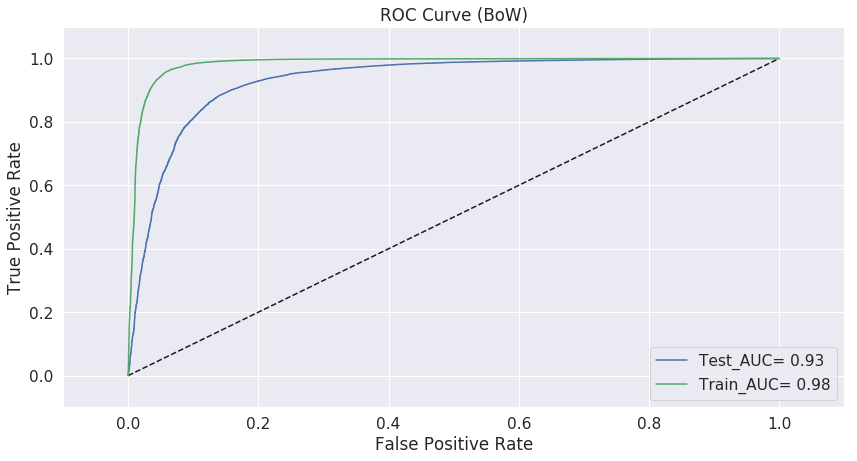

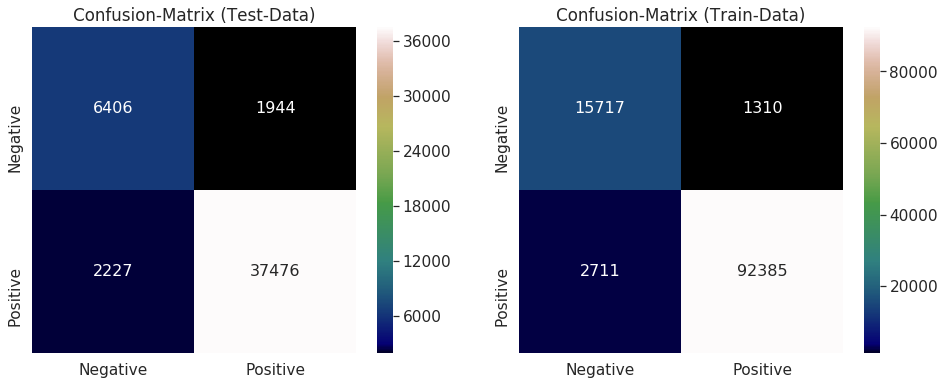

In [41]:
test_performance(calib_mod,clf,train,y_train,test,y_test,model.best_params_,vect[0],summarize,kernel[0])

#### [1.1.4] Top 10 important features of positive and negative class from<font color='red'> SET 1</font>

	Negative					Positive		
___________________________________________________________________________
	-0.0327	not buy        				0.0495	great          
	-0.0316	disappoint     				0.0477	love           
	-0.0262	not worth      				0.0354	best           
	-0.0244	not good       				0.0310	good           
	-0.0238	not recommend  				0.0301	delici         
	-0.0235	worst          				0.0241	excel          
	-0.0210	not purchas    				0.0226	perfect        
	-0.0209	terribl        				0.0215	favorit        
	-0.0203	would not      				0.0213	high recommend 
	-0.0188	not            				0.0190	tasti          


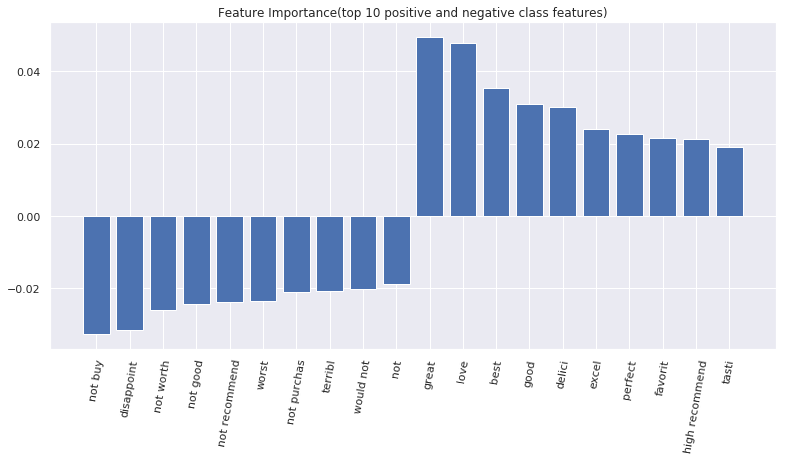

In [42]:
no_of_imp_features=10
feature_importance(count_vect,clf,no_of_imp_features)

### [2.1] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

#### [2.1.1] Hyperparam tunning and plot Hyperparam v/s Missclassification error:

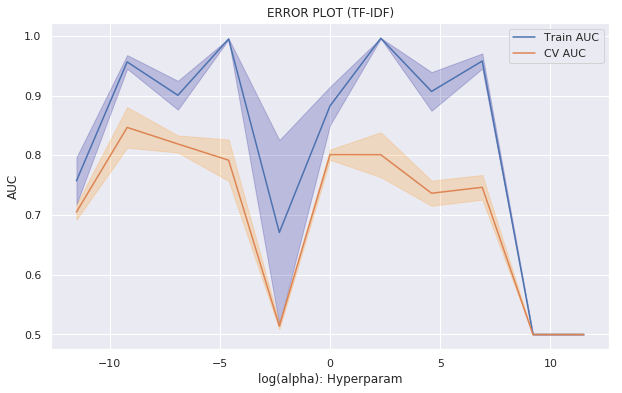

CPU times: user 21.3 s, sys: 616 ms, total: 21.9 s
Wall time: 23 s
Optimal value of hyperparam:  {'alpha': 10000.0, 'penalty': 'l2'}


In [43]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=X_train_tfidf,test=X_test_tfidf,mean=False)
#HYPERPARAM TUNNING
%time model=SVM_Classifier(train,y_train,TBS,params,searchMethod,vect[1],kernel[0])
#PRINT OPTIMAL VALUE OF HYPERPARAM
print('Optimal value of hyperparam: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_tfidf_lsvm')

#### [2.1.2] Calibration of a model and plot calibration curve :
                a. sigmoid
                b. isotonic

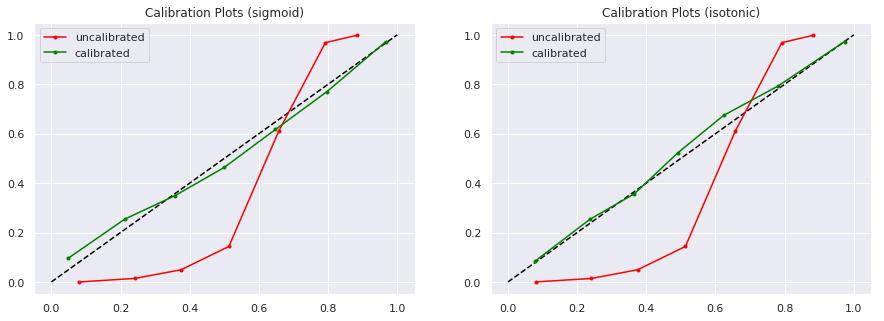

In [44]:
calibration_method=['sigmoid','isotonic']
calib_model,clf=model_calibration(train,test,y_train,y_test,model.best_params_,calibration_method,kernel[0])

## Observation:
1. From the above plot we observe that the uncalibrated curve is looks like a sigmoidal curve so we choose sigmoidal calibration.

In [45]:
calib_mod=calib_model['sigmoid']

#### [2.1.3] Performance on test data with optimal value of hyperparam:

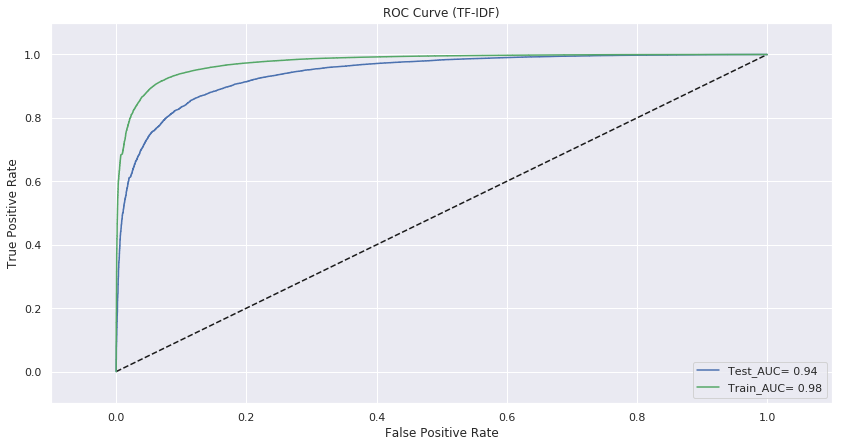

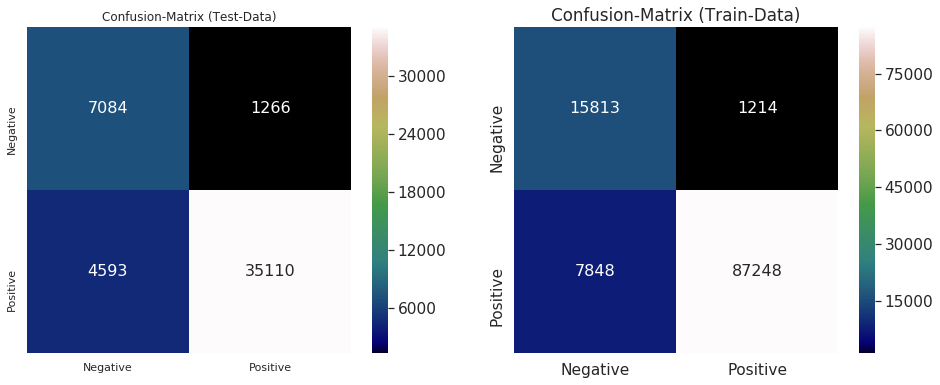

In [46]:
test_performance(calib_mod,clf,train,y_train,test,y_test,model.best_params_,vect[1],summarize,kernel[0])

#### [2.1.4] Top 10 important features of positive and negative class from<font color='red'> SET 2</font>

	Negative					Positive		
___________________________________________________________________________
	-0.0000	not            				0.0000	great          
	-0.0000	disappoint     				0.0000	love           
	-0.0000	not buy        				0.0000	best           
	-0.0000	wast           				0.0000	delici         
	-0.0000	wast money     				0.0000	perfect        
	-0.0000	return         				0.0000	favorit        
	-0.0000	worst          				0.0000	high recommend 
	-0.0000	bad            				0.0000	easi           
	-0.0000	horribl        				0.0000	find           
	-0.0000	aw             				0.0000	snack          


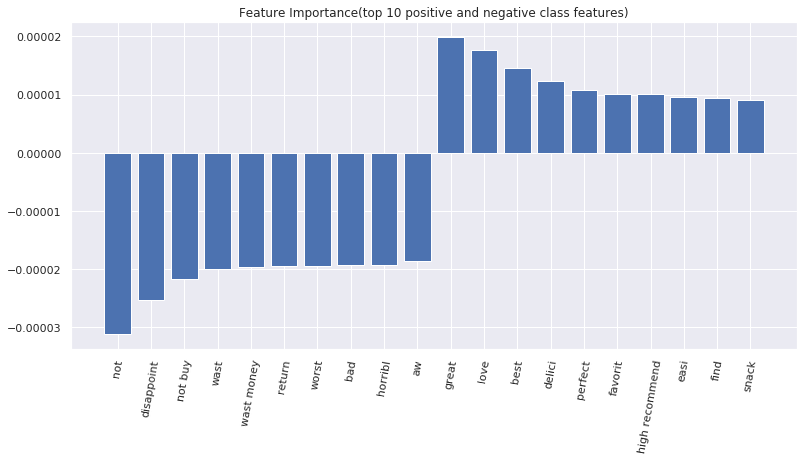

In [47]:
no_of_imp_features=10
feature_importance(tf_idf_vect,clf,no_of_imp_features)

### [3.1] Applying Linear SVM on AVG-W2V,<font color='red'> SET 3</font>

#### [3.1.1] Hyperparam tunning and draw Error plot:

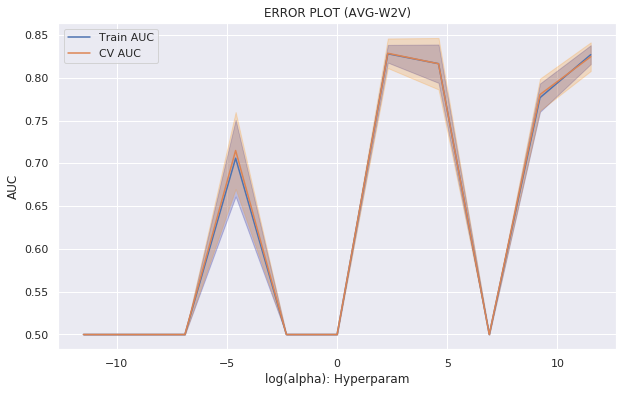

CPU times: user 21.7 s, sys: 568 ms, total: 22.3 s
Wall time: 22.9 s
Optimal value of hyperparam:  {'alpha': 0.01, 'penalty': 'l1'}


In [48]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=avg_sent_vectors,test=avg_sent_vectors_test,mean=True)
#HYPERPARAM TUNNING
%time model=SVM_Classifier(train,y_train,TBS,params,searchMethod,vect[2],kernel[0])
#PRINT OPTIMAL VALUE OF HYPERPARAM
print('Optimal value of hyperparam: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_avgw2v_lsvm')

#### [3.1.2] Calibration of a model and plot calibration curve :
                a. sigmoid
                b. isotonic

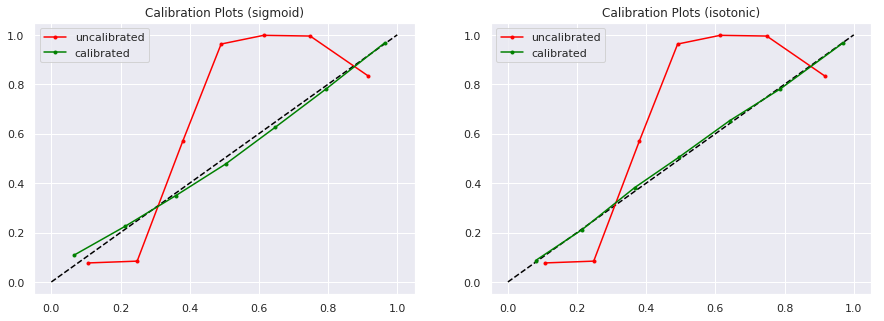

In [49]:
calibration_method=['sigmoid','isotonic']
calib_model,clf=model_calibration(train,test,y_train,y_test,model.best_params_,calibration_method,kernel[0])

## Observation:
1. From the above plot we observe that the uncalibrated curve is almost looks like a sigmoidal curve so we choose sigmoidal calibration.

In [50]:
calib_mod=calib_model['sigmoid']

#### [3.1.3] Performance on test data with optimal value of hyperparam:

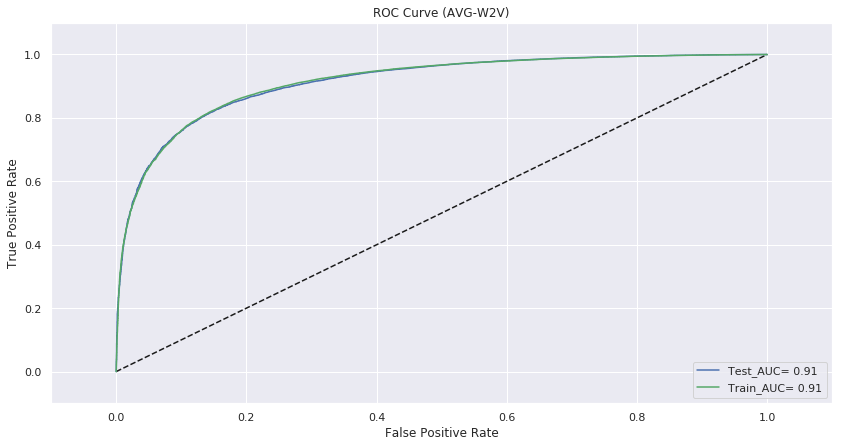

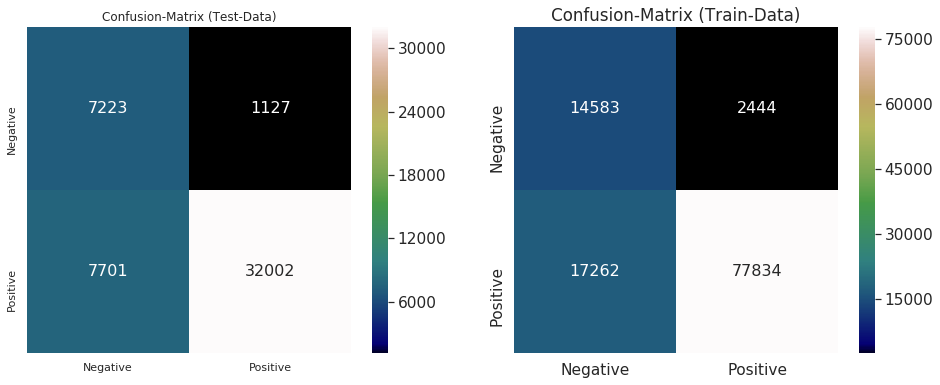

In [51]:
test_performance(calib_mod,clf,train,y_train,test,y_test,model.best_params_,vect[2],summarize,kernel[0])

### [4.1] Applying Linear SVM on TFIDF-W2V,<font color='red'> SET 4</font>

#### [4.1.1] Hyperparam tunning and plot Hyperparam v/s Missclassification error:

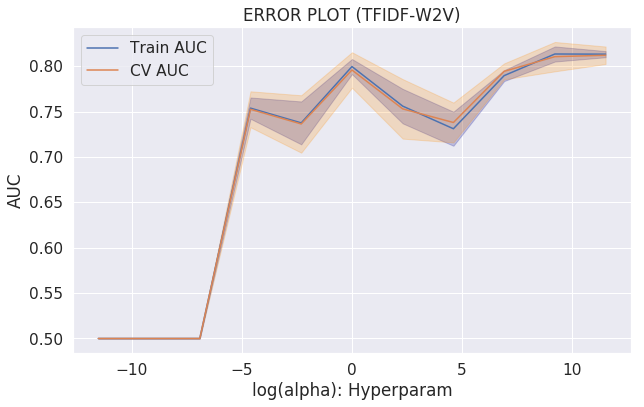

CPU times: user 21.4 s, sys: 588 ms, total: 22 s
Wall time: 22.2 s
Optimal value of hyperparam:  {'alpha': 0.1, 'penalty': 'l2'}


In [52]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=tfidf_sent_vectors,test=tfidf_sent_vectors_test,mean=True)
#HYPERPARAM TUNNING
%time model=SVM_Classifier(train,y_train,TBS,params,searchMethod,vect[3],kernel[0])
#PRINT OPTIMAL VALUE OF HYPERPARAM
print('Optimal value of hyperparam: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_tfw2v_lsvm')

#### [4.1.2] Calibration of a model and plot calibration curve :
                a. sigmoid
                b. isotonic

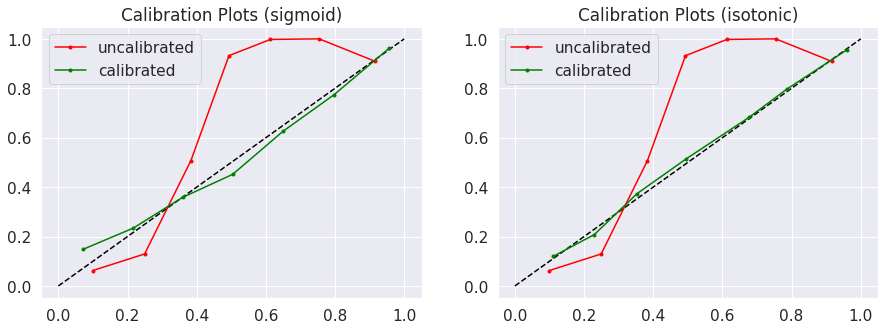

In [53]:
calibration_method=['sigmoid','isotonic']
calib_model,clf=model_calibration(train,test,y_train,y_test,model.best_params_,calibration_method,kernel[0])

## Observation:
1. From the above plot we observe that the uncalibrated curve is almost looks like a sigmoidal curve so we choose sigmoidal calibration.

In [54]:
calib_mod=calib_model['sigmoid']

#### [4.1.3] Performance on test data with optimal value of hyperparam:

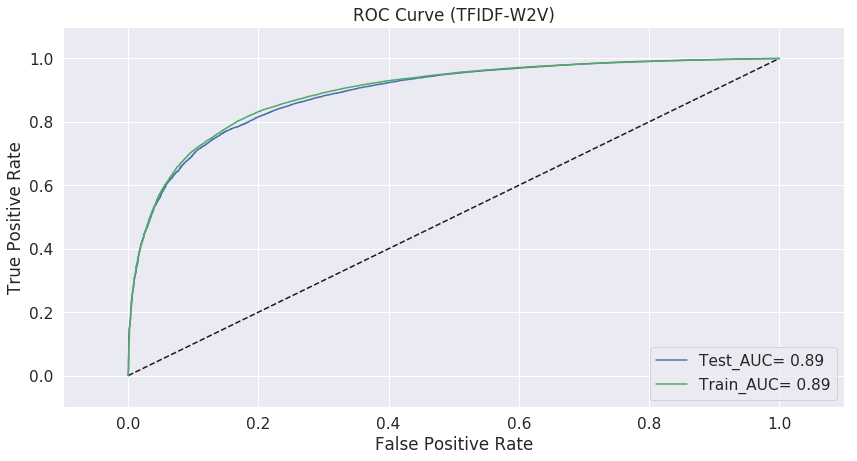

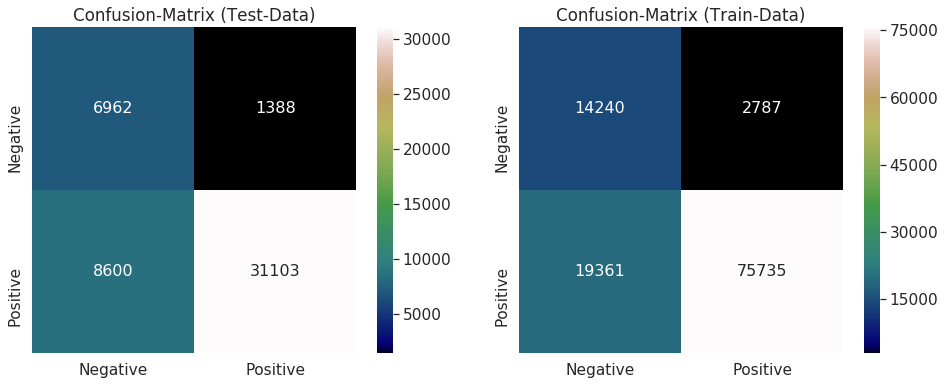

In [55]:
test_performance(calib_mod,clf,train,y_train,test,y_test,model.best_params_,vect[3],summarize,kernel[0])

## Conclusion:

In [56]:
summary_linear=summarize
print(summarize)

+------------+--------+-----------------+---------------+-----------+----------------+
| Vectorizer | Kernel | Optimal-Penalty | Optimal-Alpha | Test(AUC) | Test(f1-score) |
+------------+--------+-----------------+---------------+-----------+----------------+
|    BoW     | linear |        l2       |      1.0      |   0.9314  |     0.9138     |
|   TF-IDF   | linear |        l2       |    10000.0    |   0.9422  |     0.8855     |
|  AVG-W2V   | linear |        l1       |      0.01     |   0.9140  |     0.8339     |
| TFIDF-W2V  | linear |        l2       |      0.1      |   0.8905  |     0.8131     |
+------------+--------+-----------------+---------------+-----------+----------------+


### 1. from the above table we can observe that the optimal performance is give by:
        a. Bag of word vectorizer
        b. f1-score=.9138 and auc=.9314

## [2] RBF(Radial Basis Function) SVM

In [64]:
#INITIALIZE PRETTY TABLE OBJECT
summarize = PrettyTable()
summarize.field_names = ['Vectorizer', 'Kernel', 'Optimal-Alpha', 'Test(AUC)', 'Test(f1-score)']

### [1.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

#### [1.1.1] Hyperparam tunning and draw Error plot:

[LibSVM]

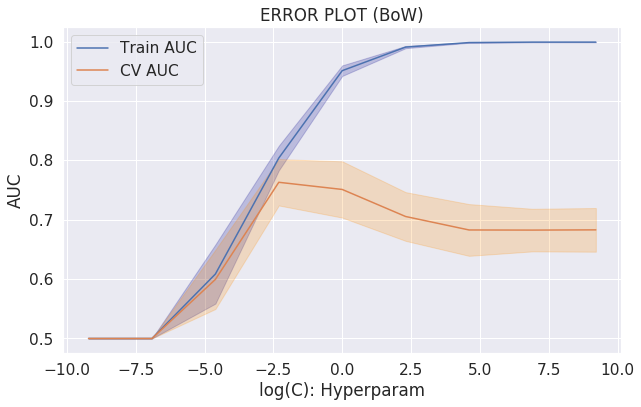

CPU times: user 3min 30s, sys: 2.51 s, total: 3min 33s
Wall time: 19min 42s
Optimal value of hyperparam:  {'C': 0.1}


In [89]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=X_train_bigram_rbf,test=X_test_bigram_rbf,mean=False)
#HYPERPARAM TUNNING
%time model=SVM_Classifier(train,y_train_rbf,TBS,params_rbf,searchMethod,vect[0],kernel[1])
#PRINT OPTIMAL VALUE OF HYPERPARAM
print('Optimal value of hyperparam: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_bow_rbfsvm')

#### [1.1.2] Calibration of a model and plot calibration curve :
                a. sigmoid
                b. isotonic

[LibSVM]

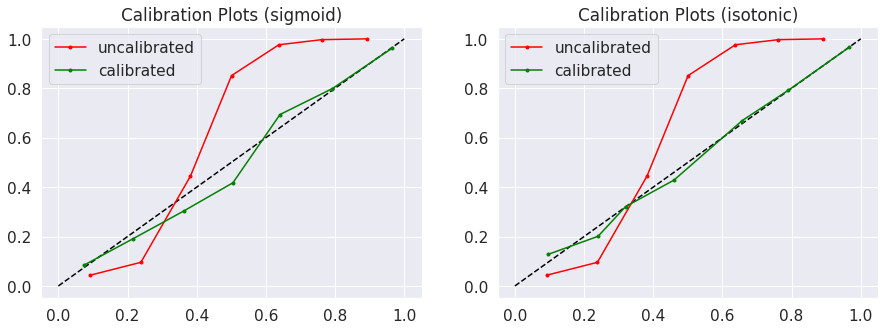

In [90]:
calibration_method=['sigmoid','isotonic']
calib_model,clf=model_calibration(train,test,y_train_rbf,y_test_rbf,model.best_params_,calibration_method,kernel[1])

## Observation:
1. From the above plot we observe that the uncalibrated curve is looks like a sigmoidal curve so we choose sigmoidal calibration.

In [91]:
calib_mod=calib_model['sigmoid']

#### [1.1.3] Performance on test data with optimal value of hyperparam:

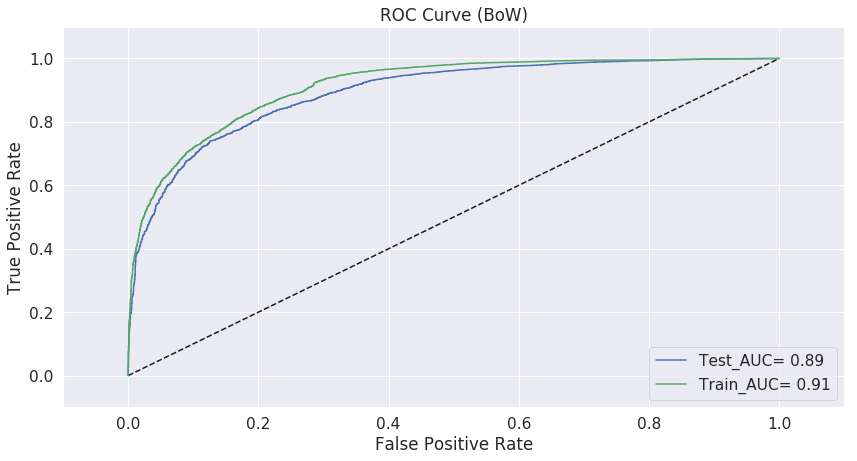

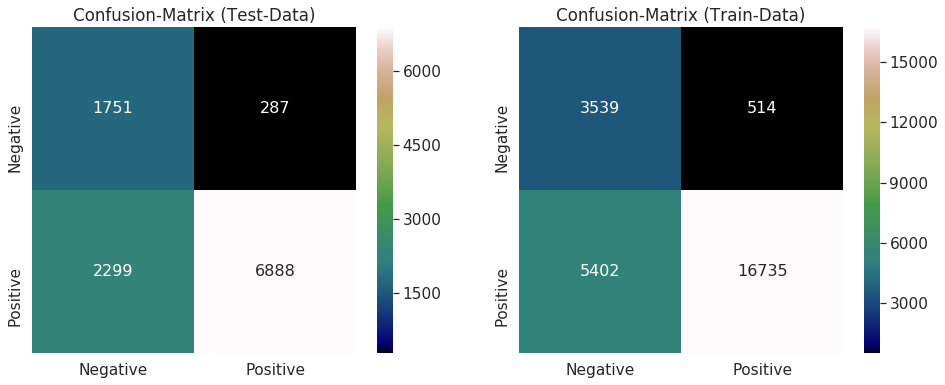

In [92]:
test_performance(calib_mod,clf,train,y_train_rbf,test,y_test_rbf,model.best_params_,vect[0],summarize,kernel[1])

### [2.1] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

#### [2.1.1] Hyperparam tunning and draw Error plot:

[LibSVM]

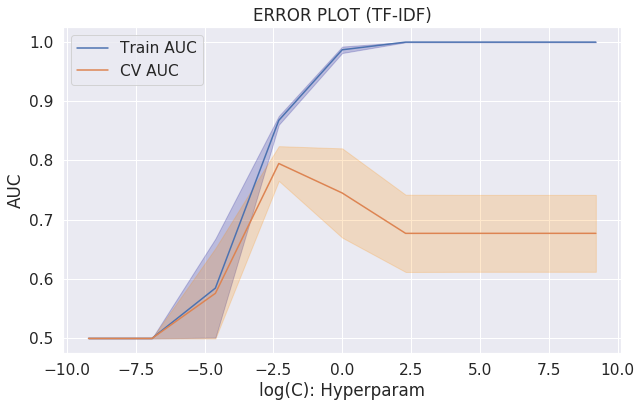

CPU times: user 3min 44s, sys: 5.38 s, total: 3min 49s
Wall time: 23min 40s
Optimal value of hyperparam:  {'C': 0.1}


In [93]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=X_train_tfidf_rbf,test=X_test_tfidf_rbf,mean=False)
#HYPERPARAM TUNNING
%time model=SVM_Classifier(train,y_train_rbf,TBS,params_rbf,searchMethod,vect[1],kernel[1])
#PRINT OPTIMAL VALUE OF HYPERPARAM
print('Optimal value of hyperparam: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_tfidf_rbfsvm')

#### [2.1.2] Calibration of a model and plot calibration curve :
                a. sigmoid
                b. isotonic

[LibSVM]

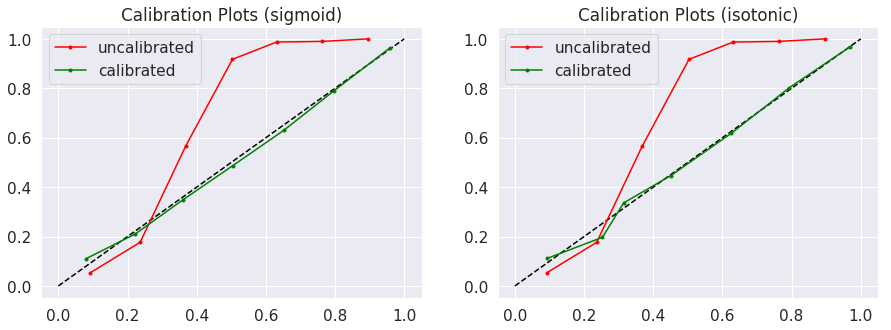

In [68]:
calibration_method=['sigmoid','isotonic']
calib_model,clf=model_calibration(train,test,y_train_rbf,y_test_rbf,model.best_params_,calibration_method,kernel[1])

## Observation:
1. From the above plot we observe that the uncalibrated curve is looks like a sigmoidal curve so we choose sigmoidal calibration.

In [69]:
calib_mod=calib_model['sigmoid']

#### [2.1.3] Performance on test data with optimal value of hyperparam:

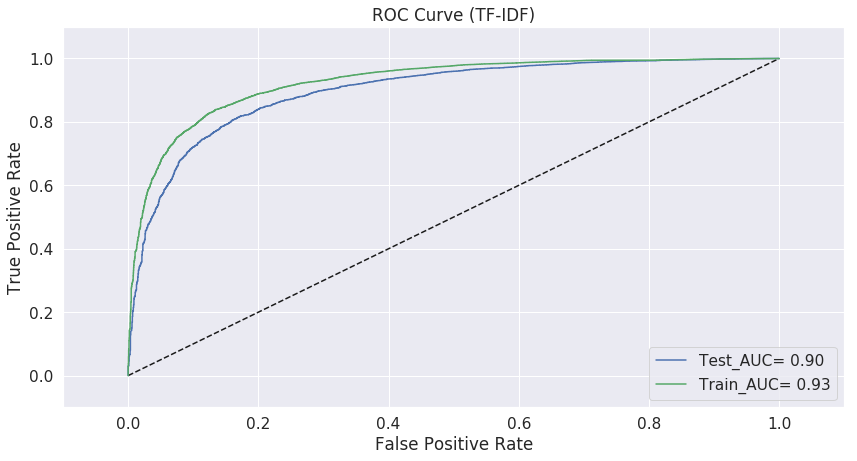

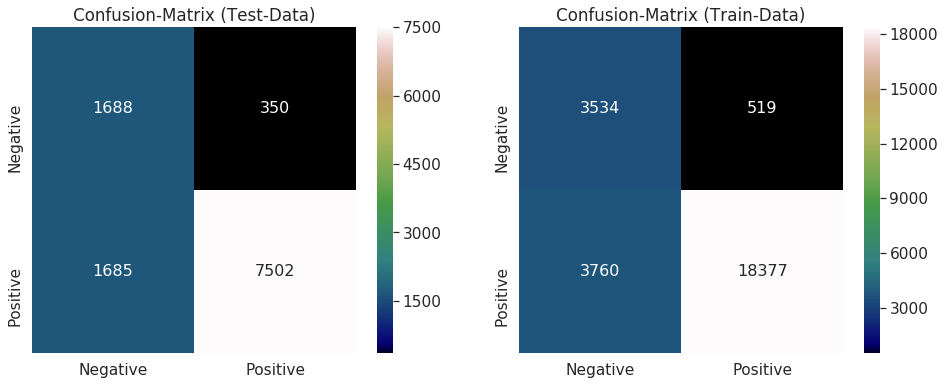

In [70]:
test_performance(calib_mod,clf,train,y_train_rbf,test,y_test_rbf,model.best_params_,vect[1],summarize,kernel[1])

### [3.1]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

#### [3.1.1] Hyperparam tunning and draw Error plot:

[LibSVM]

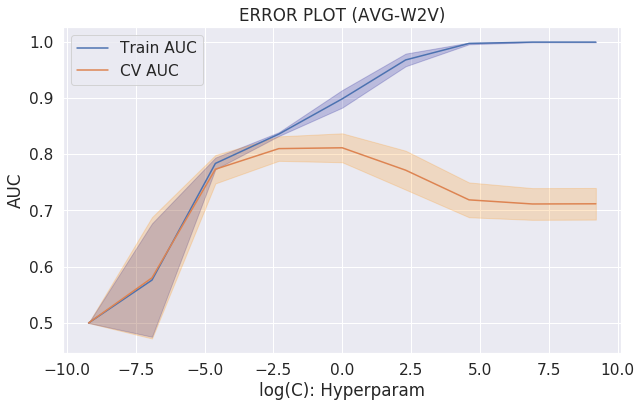

CPU times: user 1min 32s, sys: 1.5 s, total: 1min 34s
Wall time: 9min 52s
Optimal value of hyperparam:  {'C': 1}


In [76]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=avg_sent_vectors_rbf,test=avg_sent_vectors_test_rbf,mean=True)
#HYPERPARAM TUNNING
%time model=SVM_Classifier(train,y_train_rbf,TBS,params_rbf,searchMethod,vect[2],kernel[1])
#PRINT OPTIMAL VALUE OF HYPERPARAM
print('Optimal value of hyperparam: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_avgw2v_rbfsvm')

#### [3.1.2] Calibration of a model and plot calibration curve :
                a. sigmoid
                b. isotonic

[LibSVM]

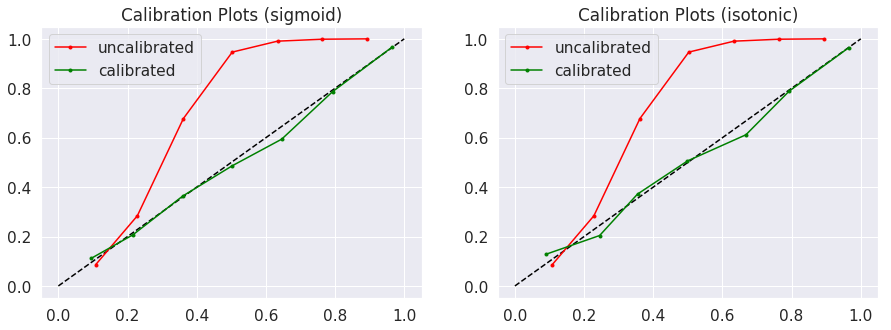

In [77]:
calibration_method=['sigmoid','isotonic']
calib_model,clf=model_calibration(train,test,y_train_rbf,y_test_rbf,model.best_params_,calibration_method,kernel[1])

## Observation:
1. From the above plot we observe that the uncalibrated curve is looks like a sigmoidal curve so we choose sigmoidal calibration.

In [78]:
calib_mod=calib_model['sigmoid']

#### [3.1.3] Performance on test data with optimal value of hyperparam:

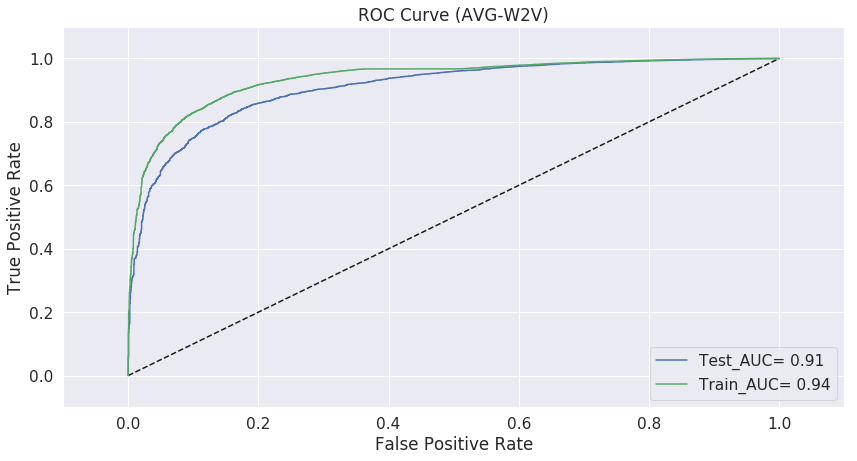

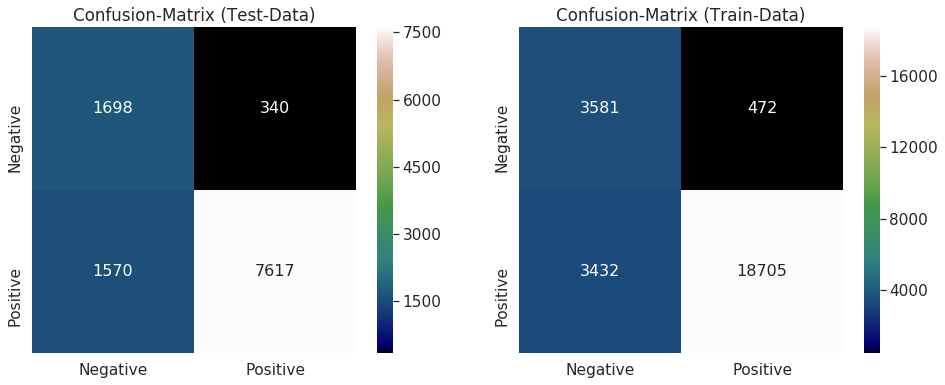

In [79]:
test_performance(calib_mod,clf,train,y_train_rbf,test,y_test_rbf,model.best_params_,vect[2],summarize,kernel[1])

### [4.1]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

#### [4.1.1] Hyperparam tunning and draw Error plot:

[LibSVM]

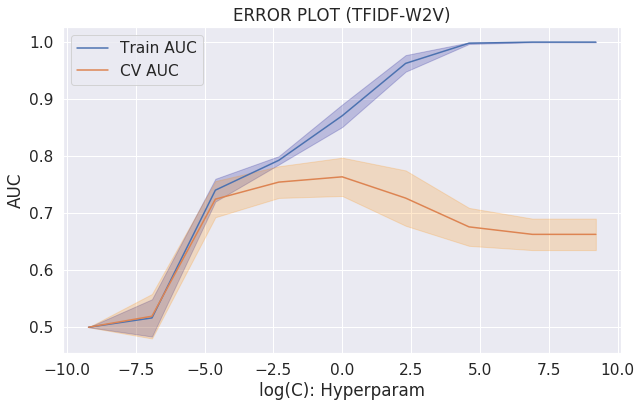

CPU times: user 1min 52s, sys: 2.28 s, total: 1min 54s
Wall time: 11min 13s
Optimal value of hyperparam:  {'C': 1}


In [83]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=tfidf_sent_vectors_rbf,test=tfidf_sent_vectors_test_rbf,mean=True)
#HYPERPARAM TUNNING
%time model=SVM_Classifier(train,y_train_rbf,TBS,params_rbf,searchMethod,vect[3],kernel[1])
#PRINT OPTIMAL VALUE OF HYPERPARAM
print('Optimal value of hyperparam: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_tfw2v_rbfsvm')

#### [4.1.2] Calibration of a model and plot calibration curve :
                a. sigmoid
                b. isotonic

[LibSVM]

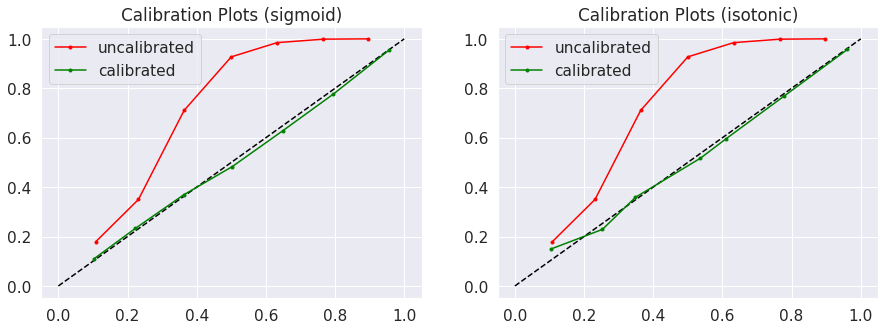

In [84]:
calibration_method=['sigmoid','isotonic']
calib_model,clf=model_calibration(train,test,y_train_rbf,y_test_rbf,model.best_params_,calibration_method,kernel[1])

## Observation:
1. From the above plot we observe that the uncalibrated curve is looks like a sigmoidal curve so we choose sigmoidal calibration.

In [85]:
calib_mod=calib_model['sigmoid']

#### [4.1.3] Performance on test data with optimal value of hyperparam:

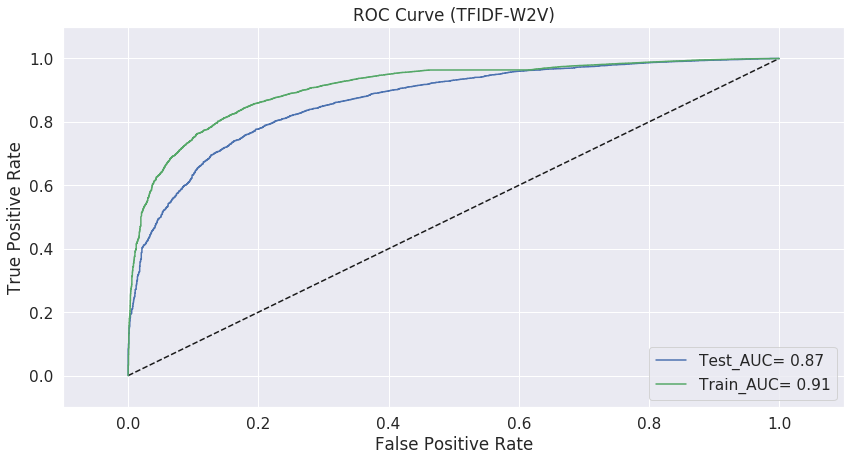

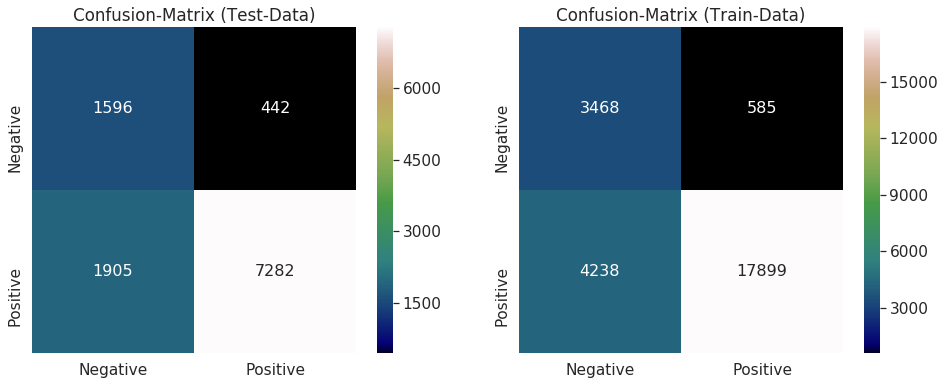

In [86]:
test_performance(calib_mod,clf,train,y_train_rbf,test,y_test_rbf,model.best_params_,vect[3],summarize,kernel[1])

## Conclusion:

In [88]:
summary_rbf=summarize
print(summarize)

+------------+--------+---------------+-----------+----------------+
| Vectorizer | Kernel | Optimal-Alpha | Test(AUC) | Test(f1-score) |
+------------+--------+---------------+-----------+----------------+
|    BoW     |  rbf   |      0.1      |   0.8933  |     0.7935     |
|   TF-IDF   |  rbf   |      0.1      |   0.8974  |     0.8340     |
|  AVG-W2V   |  rbf   |       1       |   0.9086  |     0.8435     |
| TFIDF-W2V  |  rbf   |       1       |   0.8676  |     0.8095     |
+------------+--------+---------------+-----------+----------------+


### 1. from the above table we can observe that the optimal performance is give by:
        a. AVGW2V vectorizer
        b. f1-score=.8435 and auc=.9086

# --------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------

## Model performance summary for both RBF and LINEAR Kernel:

In [82]:
print('SVM with LINEAR KERNEL SUMMARY:\n',summary_linear)
print('SVM with RBF KERNEL SUMMARY:\n',summary_rbf)

SVM with LINEAR KERNEL SUMMARY:
 +------------+--------+-----------------+---------------+-----------+----------------+
| Vectorizer | Kernel | Optimal-Penalty | Optimal-Alpha | Test(AUC) | Test(f1-score) |
+------------+--------+-----------------+---------------+-----------+----------------+
|    BoW     | linear |        l2       |      1.0      |   0.9314  |     0.9138     |
|   TF-IDF   | linear |        l2       |    10000.0    |   0.9422  |     0.8855     |
|  AVG-W2V   | linear |        l1       |      0.01     |   0.9140  |     0.8339     |
| TFIDF-W2V  | linear |        l2       |      0.1      |   0.8905  |     0.8131     |
+------------+--------+-----------------+---------------+-----------+----------------+
SVM with RBF KERNEL SUMMARY:
 +------------+--------+---------------+-----------+----------------+
| Vectorizer | Kernel | Optimal-Alpha | Test(AUC) | Test(f1-score) |
+------------+--------+---------------+-----------+----------------+
|    BoW     |  rbf   |      0.1  

Reference Links:
1. https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
2. https://www.appliedaicourse.com/